In [1]:
import pickle as pkl
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
SAVE_FIGURES = False

In [3]:
cpath=os.path.curdir

In [4]:
os.getcwd()

'/home/jyler/projects/compare-latent-spaces-amps'

In [5]:
def grab_prop_boloop_data(prop, verbose=False):
    # prop = 'hydrophobicity'
    
    if prop=="boman":
        prop_title = "Boman"
        prop="peptides-boman-z"
        percentages = [25,50,75,98]
    elif prop=="charge":
        prop_title="Charge(pH=7.2)"
        prop="peptides-chargepH7p2-z"
        percentages = [25,50,75,98]
    elif prop=="hydrophobicity":
        prop_title = "Hydrophobicity"
        prop="peptides-hydrophobicity-z"
        percentages = [25,50,75,98]
    elif prop=="bc":
        prop_title = "Boman-Charge(pH=7.2)"
        prop="peptides-boman-chargepH7p2-z"
        percentages=[25,50,75,98]
    elif prop=="bch":
        prop_title = "Boman-Charge(pH=7.2)-Hydrophobicity"
        prop="bch"
        percentages=[0]#,25,50,75,98]
    elif prop=="predicted-log10mic":
        prop_title = prop
        percentages=[0]
    
    run_files = []
    data_diff5 = {}
    for _perc in percentages:
        data_diff5[str(_perc)]={}

    print("getting files")
    for _D in model_dirs:
        if not os.path.isdir(_D+"/boloop_results"):
            continue
            
        for _d in os.listdir(_D+"/boloop_results/"):
            condn1 = (prop in _d)
            condn2 = (os.path.isdir(_D+"/boloop_results/"))
            if condn1 and condn2:
                run_files = os.listdir(_D+"/boloop_results/")
        
                _dir = run_files
                for _f in run_files:
                    if _f.startswith("boloop_results"):
                        continue
                    _fpath = _D+"/boloop_results/"+_f
                # for _f in os.listdir(diff5_bcg):
                    for _perc in percentages:
                        if _perc==0:
                            condn_perc = ("zScoreNormalized-organized-cdhit90-zScoreNormalized" in _f)
                        else:
                            condn_perc = (f"-{_perc}-" in _f)
                        if condn_perc:
                            print(_D)
                            _run = _f[-8:-4]
                            with open(_fpath, 'rb') as fr:
                                data_diff5[str(_perc)][_run] = pkl.load(fr)

    #############################
    #############################
    ### re-format into pandas dataframes
    #############################
    #############################
    dataframes = {}
    dataframes_scores = {}
    melted_dataframes = {}
    candidate_scores_df = {}
    print("making dataframes")
    for _perc in percentages:
        dataframes[         str(_perc)] = pd.DataFrame()
        melted_dataframes[  str(_perc)] = pd.DataFrame()
    
        dataframes_scores[  str(_perc)] = pd.DataFrame()
        candidate_scores_df[str(_perc)] = pd.DataFrame()
    
    
    min_common_iteration=1000
    if verbose:
        print("first loop")
    for _perc in percentages:
        if verbose:
            print(f"{_perc=}")        
        for _k, _v in data_diff5[ str(_perc) ].items():
            if verbose:
                print(f"{_v.keys}")
                print(f"{len(_v['best_objective_values'])=}")
            _len = len(_v['best_objective_values'])
            if _len<=min_common_iteration:
                min_common_iteration = _len
    
    if verbose:
        print("second loop")
    for _perc in percentages:
        if verbose:
            print(f"{_perc=}")
        for _k, _v in data_diff5[ str(_perc) ].items():
            if verbose:
                print(f"{_v }")
            _len = len(_v['best_objective_values'])
            dataframes[       str(_perc)][_k] = _v['best_objective_values'] + [np.nan]*(1000-_len)
            dataframes_scores[str(_perc)][_k] = _v[     'candidate_scores'] + [np.nan]*(1000-_len)
            
    
        dataframes[str(_perc)]['iteration'] = list(range(len(dataframes[str(_perc)])))
        dataframes_scores[str(_perc)]['iteration'] = list(range(len(dataframes[str(_perc)])))

        # ensure all runs have the same number of non-NaNs | run3, run1, run4, run0, run2
        _most_nans = dataframes[str(_perc)][ ["run3", "run1", "run4", "run0", "run2"] ].isna().sum(axis=0)
        _most_nans_col = _most_nans.idxmax()
        _most_nans_bools = ( dataframes[str(_perc)][ _most_nans_col ].isna() )
        for _run in ["run3", "run1", "run4", "run0", "run2"]:
            dataframes[str(_perc)][_run][ _most_nans_bools ] = np.nan
        
        melted_dataframes[str(_perc)]   = dataframes[str(_perc)].melt( id_vars="iteration", var_name="run", value_name="best_score")
        candidate_scores_df[str(_perc)] = dataframes_scores[str(_perc)].melt( id_vars="iteration", var_name="run", value_name="candidate_scores")
    
    return melted_dataframes, candidate_scores_df, prop_title

In [6]:
prop="bch"
dim_method = "PCA"
_perc = 98
_n_initialization_points=100
if prop=="bc":
    prop = "boman-chargepH7p2"
elif prop=="c":
    prop = "chargepH7p2"
elif prop=="h":
    prop = "hydrophobicity"
    
if _perc == 0:
    perc = ""
else:
    perc = f"{_perc}-"

boloop_dir_suffix = ""
if _n_initialization_points<100:
    boloop_dir_suffix = f"_{_n_initialization_points}_init_points"


_model_name = f"transvae-64-peptides-{prop}-zScoreNormalized-{perc}organized-cdhit90-zScoreNormalized"

with open(f"analysis/{_model_name}/boloop_results{boloop_dir_suffix}/boloop_results_{dim_method}_neg10to10_{_model_name}_log10_mic.pkl",'rb') as f:
    runs=pkl.load(f)

In [7]:
print(_model_name)
print(runs.keys())
print(runs['run_0'].keys())


transvae-64-peptides-bch-zScoreNormalized-98-organized-cdhit90-zScoreNormalized
dict_keys(['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'params'])
dict_keys(['iterations', 'candidates', 'candidate_scores', 'best_objective_values', 'best_sequences', 'params'])


In [8]:
data=pd.DataFrame()
for i in range(5):
    if i==0:
        data['iterations']=runs[f"run_{i}"]['iterations']
    data[f"run{i}"]=runs[f"run_{i}"]["best_objective_values"]

melted_data = pd.melt(data, id_vars=["iterations"], value_vars=[f"run{i}" for i in range(5)])

In [9]:
melted_data.groupby("variable").min()

,iterations,value
variable,,
run0,1,-0.429788
run1,1,-0.400500
run2,1,0.051665
run3,1,-0.697710
run4,1,-0.306282


In [10]:
markers=[".",'o','^','v']
dash = (3,1)
dot = (1,1)
line_style_options = {
   100:"solid",
    50:(0, dash),
    10:(0, dash+dot),
    1:(0, dash+dot+dot),
    20:(0, dash+dash+dot),
}

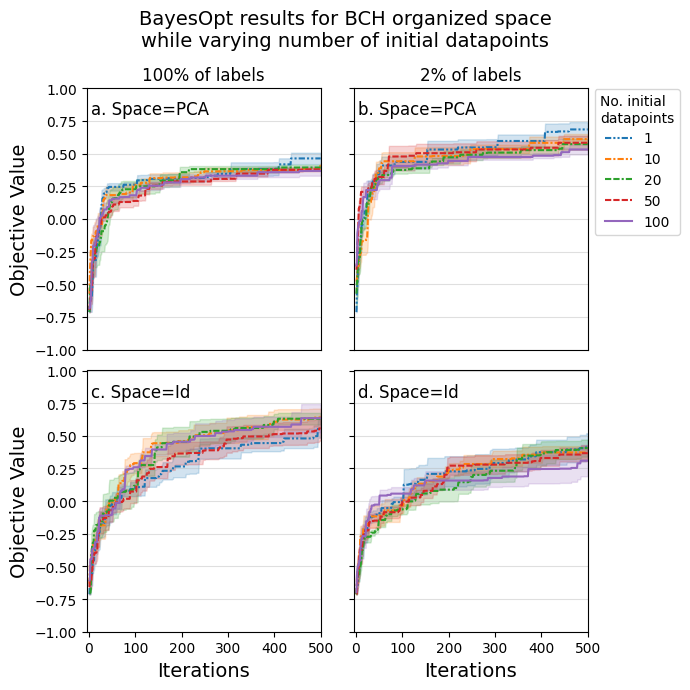

In [11]:
# plt.rcParams["font.size"]=14
fontsize=14

fig = plt.figure(figsize=(7,7))
grid= fig.add_gridspec(2,2)

prop="bch"
dim_method = "identity"
_perc = 0
index_to_panel_letter = {
    (0,0):"a. ",
    (0,1):"b. ",
    (1,0):"c. ",
    (1,1):"d. "
}
for _dim_i, dim_method in enumerate(["PCA","identity"]):
    for _perc_i, _perc in enumerate([0, 98]):
        ax = fig.add_subplot(grid[_dim_i, _perc_i])    
        # ax.set_title(f"Mask={_perc}% Space={dim_method}", y=0.89, x=0.45 + 0.05*_dim_i + 0.01*_perc_i)
        ax.set_ylim([-1.0,1.0])
        ax.set_ylabel("Objective Value", fontsize=fontsize)
        ax.grid(axis='y',alpha=0.4)
        if dim_method=="identity":
            _dim_text = "Id"
        if dim_method=="PCA":
            _dim_text = "PCA"
        ax.text(5, 0.8, f"{index_to_panel_letter[(_dim_i, _perc_i)]}Space={_dim_text}", fontsize=12 )

        for _n_initialization_points in [1,10,20,50,100]:
            # _n_initialization_points=100
            if prop=="bc":
                prop = "boman-chargepH7p2"
            elif prop=="c":
                prop = "chargepH7p2"
            elif prop=="h":
                prop = "hydrophobicity"
                
            if _perc == 0:
                perc = ""
            else:
                perc = f"{_perc}-"
            
            boloop_dir_suffix = ""
            if _n_initialization_points<100:
                boloop_dir_suffix = f"_{_n_initialization_points}_init_points"
            
            
            _model_name = f"transvae-64-peptides-{prop}-zScoreNormalized-{perc}organized-cdhit90-zScoreNormalized"

            try:
                with open(f"analysis/{_model_name}/boloop_results{boloop_dir_suffix}/boloop_results_{dim_method}_neg10to10_{_model_name}_log10_mic.pkl",'rb') as f:
                    runs=pkl.load(f)
            except FileNotFoundError:
                print("FileNotFoundError encountered")
                continue
            
            data=pd.DataFrame()
            for i in range(5):
                if i==0:
                    data['iterations']=runs[f"run_{i}"]['iterations']
                data[f"run{i}"]=runs[f"run_{i}"]["best_objective_values"]
            
            melted_data = pd.melt(data, id_vars=["iterations"], value_vars=[f"run{i}" for i in range(5)])
            
            
            
            ax = sns.lineplot(data=melted_data, 
                         x="iterations",
                         y="value", 
                         label=str(_n_initialization_points),
                         errorbar='se',
                         linestyle=line_style_options[_n_initialization_points],#line_style_options[j],
                         ax=ax
            )
            ax.legend_.remove()

            if _dim_i==0 and _perc_i==1:
                ax.legend(title="No. initial\ndatapoints", bbox_to_anchor=(1.0,1.025))

            if _perc_i==1:
                ax.set_yticklabels([])
                ax.set_ylabel("")

            if _dim_i==0:
                ax.set_title(f"{100-_perc}% of labels")
                ax.set_xticks([])
                ax.set_xlabel("")
                ax.set_xlim([-5,500])
            else:
                ax.set_xlabel("Iterations", fontsize=fontsize)
                ax.set_xticks([0,100,200,300,400,500],
                              labels=[f"{int(x*100)}" for x in range(6)]
                 )
                ax.set_xlim([-5,500])

fig.suptitle("BayesOpt results for BCH organized space\nwhile varying number of initial datapoints", fontsize=fontsize)
fig.tight_layout(h_pad=0.5)

if SAVE_FIGURES:
    fig.savefig(f"figures/boloop_results_vary_num_init_points_BCH.svg",dpi=300)
    fig.savefig(f"figures/boloop_results_vary_num_init_points_BCH.eps",dpi=300)


# Predicted log10mic as the organizing property

/tmp/ipykernel_23225/1383569877.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(_yticklabels, fontsize=14)
/tmp/ipykernel_23225/1383569877.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(_yticklabels, fontsize=14)
/tmp/ipykernel_23225/1383569877.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(_yticklabels, fontsize=14)
/tmp/ipykernel_23225/1383569877.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(_yticklabels, fontsize=14)
/tmp/ipykernel_23225/1383569877.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_t

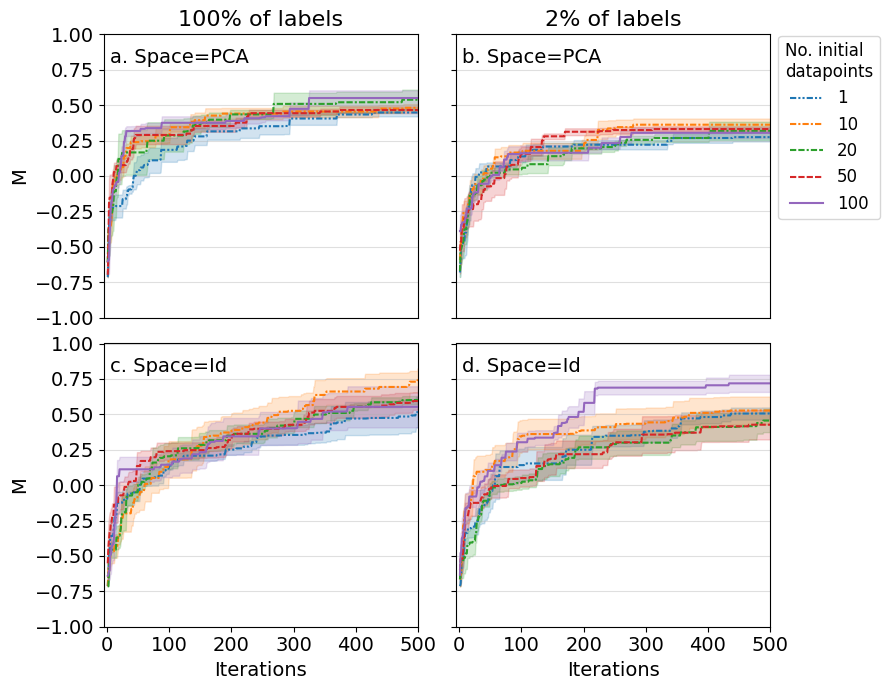

In [32]:
# plt.rcParams["font.size"]=14
fontsize=14

fig = plt.figure(figsize=(9,7))
grid= fig.add_gridspec(2,2)

prop="predicted-log10mic"
dim_method = "identity"
_perc = 0
index_to_panel_letter = {
    (0,0):"a. ",
    (0,1):"b. ",
    (1,0):"c. ",
    (1,1):"d. "
}
percentages = [0,98]
dim_methods = ["PCA","identity"]
for _dim_i, dim_method in enumerate(dim_methods):
    for _perc_i, _perc in enumerate(percentages):
        ax = fig.add_subplot(grid[_dim_i, _perc_i])    
        # ax.set_title(f"Mask={_perc}% Space={dim_method}", y=0.89, x=0.45 + 0.05*_dim_i + 0.01*_perc_i)
        ax.set_ylim([-1.0,1.0])
        ax.set_ylabel("M", fontsize=fontsize)
        ax.grid(axis='y',alpha=0.4)
        if dim_method=="identity":
            _dim_text = "Id"
        if dim_method=="PCA":
            _dim_text = "PCA"
        ax.text(5, 0.8, f"{index_to_panel_letter[(_dim_i, _perc_i)]}Space={_dim_text}", fontsize=14 )

        for _n_initialization_points in [1,10,20,50,100]:
            # _n_initialization_points=100
            if prop=="bc":
                prop = "boman-chargepH7p2"
            elif prop=="c":
                prop = "chargepH7p2"
            elif prop=="h":
                prop = "hydrophobicity"
                
            if _perc == 0:
                perc = "0-"
            else:
                perc = f"{_perc}-"
            
            boloop_dir_suffix = ""
            if _n_initialization_points<100:
                boloop_dir_suffix = f"_{_n_initialization_points}_init_points"
            
            
            _model_name = f"transvae-64-peptides-{prop}-zScoreNormalized-{perc}organized-cdhit90-zScoreNormalized"

            try:
                with open(f"analysis/{_model_name}/boloop_results{boloop_dir_suffix}/boloop_results_{dim_method}_neg10to10_{_model_name}_log10_mic.pkl",'rb') as f:
                    runs=pkl.load(f)
            except FileNotFoundError:
                continue
            
            data=pd.DataFrame()
            for i in range(5):
                if i==0:
                    data['iterations']=runs[f"run_{i}"]['iterations']
                data[f"run{i}"]=runs[f"run_{i}"]["best_objective_values"]
            
            melted_data = pd.melt(data, id_vars=["iterations"], value_vars=[f"run{i}" for i in range(5)])
            
            
            
            ax = sns.lineplot(data=melted_data, 
                         x="iterations",
                         y="value", 
                         label=str(_n_initialization_points),
                         errorbar='se',
                         linestyle=line_style_options[_n_initialization_points],#line_style_options[j],
                         ax=ax
            )
            ax.legend_.remove()

            if _dim_i==0 and _perc_i==1:
                ax.legend(title="No. initial\ndatapoints", 
                          bbox_to_anchor=(1.0,1.025), 
                          fontsize=12,
                         title_fontsize=12)

            if _perc_i==1:
                ax.set_yticklabels([])
                ax.set_ylabel("")

            if _dim_i==0:
                ax.set_title(f"{100-_perc}% of labels", fontsize=16)
                ax.set_xticks([])
                ax.set_xlabel("")
                ax.set_xlim([-5,500])
            else:
                ax.set_xlabel("Iterations", fontsize=fontsize)
                ax.set_xticks([0,100,200,300,400,500],
                              labels=[f"{int(x*100)}" for x in range(6)],
                              fontsize=14
                 )
                ax.set_xlim([-5,500])

            _yticklabels = ax.get_yticklabels()
            ax.set_yticklabels(_yticklabels, fontsize=14)

# fig.suptitle(f"BayesOpt results for {prop} organized space\nwhile varying number of initial datapoints", fontsize=fontsize)
fig.tight_layout(h_pad=0.5)

if SAVE_FIGURES:
    fig.savefig(f"figures/boloop_results_vary_num_init_points_predictedLog10mic.svg",dpi=300)
    # fig.savefig(f"figures/boloop_results_vary_num_init_points_predictedLog10mic.eps",dpi=300)
